**Titanic - Machine Learning from Disaster**

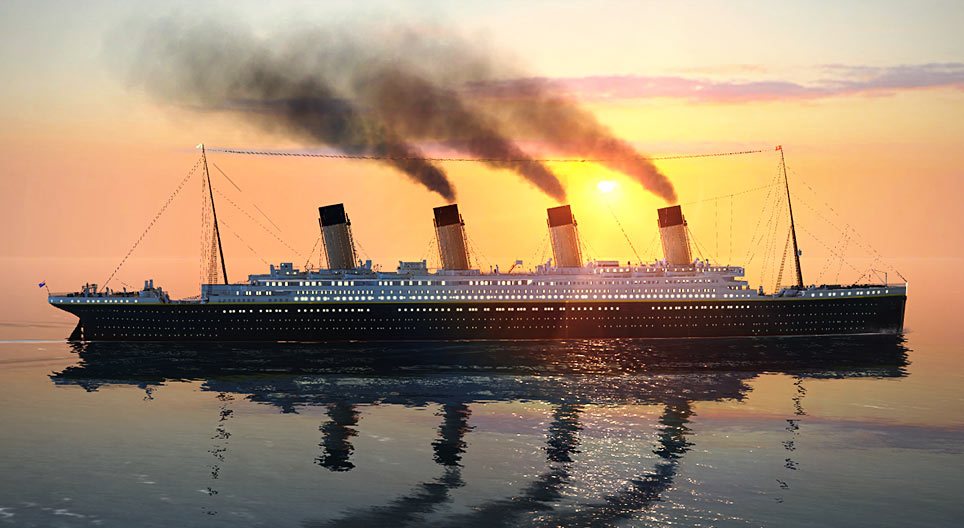

Overview
The data has been split into two groups:

training set (train.csv)
test set (test.csv)
The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

We also include gender_submission.csv, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.

# Data Preprocessing

In [1]:
#import thư viện
import pandas as pd
import numpy as np

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [3]:
print('Train set shape:', train_df.shape)
train_df.head()

Train set shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
print('Test set shape:', test_df.shape)
test_df.head()

Test set shape: (418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


+ PassengerId: ID duy nhất (không có giá trị dự đoán)

+ Survived: Target variable (0/1)

+ Pclass: Hạng vé (1, 2, 3)

+ Name: Tên hành khách

+ Sex: Giới tính (male/female)

+ Age: Tuổi

+ SibSp: Số anh chị em/vợ chồng đi cùng

+ Parch: Số cha mẹ/con cái đi cùng

+ Ticket: Số vé

+ Fare: Giá vé

+ Cabin: Số cabin

+ Embarked: Cảng lên tàu (C, Q, S)

### Missing Values

In [5]:
train_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
missing_percent = train_df.isna().mean() * 100
missing_summary = pd.DataFrame({
    'Missing Values': train_df.isna().sum(),
    'Percent (%)': missing_percent
})
print(missing_summary)

             Missing Values  Percent (%)
PassengerId               0     0.000000
Survived                  0     0.000000
Pclass                    0     0.000000
Name                      0     0.000000
Sex                       0     0.000000
Age                     177    19.865320
SibSp                     0     0.000000
Parch                     0     0.000000
Ticket                    0     0.000000
Fare                      0     0.000000
Cabin                   687    77.104377
Embarked                  2     0.224467


Xử lý missing values cho Age bằng median theo Sex và Pclass

In [7]:
age_missing_pattern = train_df.groupby(['Sex', 'Pclass'])['Age'].agg(['count', 'mean', 'median'])
print(age_missing_pattern)

               count       mean  median
Sex    Pclass                          
female 1          85  34.611765    35.0
       2          74  28.722973    28.0
       3         102  21.750000    21.5
male   1         101  41.281386    40.0
       2          99  30.740707    30.0
       3         253  26.507589    25.0


In [8]:
median_age = train_df.groupby(['Sex', 'Pclass'])['Age'].median()

# train: lấp bằng median theo nhóm
train_df['Age'] = train_df.groupby(['Sex', 'Pclass'])['Age'] \
                          .transform(lambda s: s.fillna(s.median()))

# test: dùng median đã fit từ train, fallback sang median toàn cục nếu thiếu key
global_median = train_df['Age'].median()
test_df['Age'] = test_df.apply(
    lambda row: row['Age']
    if pd.notna(row['Age'])
    else median_age.get((row['Sex'], row['Pclass']), global_median),
    axis=1,
)

In [9]:
train_df['Age'].isna().sum()
test_df['Age'].isna().sum()

np.int64(0)

Xử lý missing values cho Cabin

In [10]:
train_df['Cabin'].dropna().unique()

array(['C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6', 'C23 C25 C27',
       'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33', 'F G73', 'E31',
       'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101', 'F E69', 'D47',
       'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4', 'A32', 'B4',
       'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35', 'C87', 'B77',
       'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19', 'B49', 'D',
       'C22 C26', 'C106', 'C65', 'E36', 'C54', 'B57 B59 B63 B66', 'C7',
       'E34', 'C32', 'B18', 'C124', 'C91', 'E40', 'T', 'C128', 'D37',
       'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44', 'A34', 'C104',
       'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14', 'B37', 'C30',
       'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38', 'B39', 'B22',
       'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68', 'B41', 'A20',
       'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48', 'E58', 'C126',
       'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63', 'C62 C64',
       'E24

+ HasCabin cho biết vé có ghi cabin (1) hay không (0).

+ Deck lấy chữ cái đầu (boong) và gán 'U' cho phần thiếu.

In [11]:
for df in (train_df, test_df):
    df['HasCabin'] = df['Cabin'].notna().astype(int)
    df['Deck'] = df['Cabin'].str[0].fillna('U')

Loại bỏ cột Cabin

In [12]:
df.drop(columns='Cabin', inplace=True)

In [13]:
train_df[['HasCabin', 'Deck']].head()
train_df['Deck'].value_counts()

Deck
U    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: count, dtype: int64

One-hot encode Deck để chuyển nhãn chữ cái thành nhiều cột nhị phân

In [14]:
deck_cols = pd.get_dummies(train_df['Deck'], prefix='Deck')
train_df = pd.concat([train_df.drop(columns=['Deck', 'Cabin']),
                      deck_cols], axis=1)

Kiểm tra lại sau khi thực hiện One-hot encode Desk

In [15]:
train_df.filter(like='Deck_').head()

,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_U
0,False,False,False,False,False,False,False,False,True
1,False,False,True,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,True
3,False,False,True,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,True


Áp dụng lên tập test

In [16]:
test_deck_cols = pd.get_dummies(test_df['Deck'], prefix='Deck')
test_deck_cols = test_deck_cols.reindex(columns=deck_cols.columns, fill_value=0)
test_df = pd.concat(
    [
        test_df.drop(columns=[c for c in ['Deck', 'Cabin'] if c in test_df.columns]),
        test_deck_cols,
    ],
    axis=1,
)

test_df.filter(like='Deck_').head()


,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_U
0,False,False,False,False,False,False,False,0,True
1,False,False,False,False,False,False,False,0,True
2,False,False,False,False,False,False,False,0,True
3,False,False,False,False,False,False,False,0,True
4,False,False,False,False,False,False,False,0,True


Xử lý missing values cho Embarked

In [17]:
most_freq_embarked = train_df['Embarked'].mode()[0]
train_df.loc[train_df['Embarked'].isna(), 'Embarked'] = most_freq_embarked

Xử lý missing values cho Fare

In [18]:
fare_by_pclass = train_df.groupby('Pclass')['Fare'].median()

mask = test_df['Fare'].isna()
test_df.loc[mask, 'Fare'] = test_df.loc[mask, 'Pclass'].map(fare_by_pclass)

# nếu nhóm Pclass không tồn tại (hiếm), fallback sang median toàn cục
test_df['Fare'] = test_df['Fare'].fillna(train_df['Fare'].median())

Kiểm tra lại giá trị bị thiếu ở 2 tập

In [19]:
missing_summary = pd.DataFrame({
    'train_missing': train_df.isna().sum(),
    'test_missing': test_df.isna().sum(),
})
missing_summary

,train_missing,test_missing
Age,0,0.0
Deck_A,0,0.0
Deck_B,0,0.0
Deck_C,0,0.0
Deck_D,0,0.0
Deck_E,0,0.0
Deck_F,0,0.0
Deck_G,0,0.0
Deck_T,0,0.0
Deck_U,0,0.0


Gán biến nhị phân cho cột Sex

In [20]:
train_df['Sex'].dropna().unique()

array(['male', 'female'], dtype=object)

In [21]:
sex_map = {'male': 1, 'female': 0}

for df in (train_df, test_df):
    df['Sex'] = df['Sex'].map(sex_map).astype(int)


In [22]:
train_df['Sex'].dropna().unique()

array([1, 0])

In [23]:
train_df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex              int64
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Embarked        object
HasCabin         int64
Deck_A            bool
Deck_B            bool
Deck_C            bool
Deck_D            bool
Deck_E            bool
Deck_F            bool
Deck_G            bool
Deck_T            bool
Deck_U            bool
dtype: object

# Feature Engineering

**Title từ Name**

In [24]:
title_pattern = r",\s*([^\.]+)\."
title_map = {
    "Mlle": "Miss",
    "Ms": "Miss",
    "Mme": "Mrs",
    "Lady": "Royalty",
    "Countess": "Royalty",
    "Sir": "Royalty",
    "Don": "Royalty",
    "Jonkheer": "Royalty",
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Dr": "Officer",
    "Rev": "Clergy",
}

for df in (train_df, test_df):
    df["Title"] = (
        df["Name"]
        .str.extract(title_pattern, expand=False)  # lấy đoạn giữa dấu phẩy và dấu chấm
        .str.strip()
    )
    df["Title"] = df["Title"].replace(title_map)
    df["Title"] = df["Title"].fillna("Unknown")

In [25]:
title_cols = pd.get_dummies(train_df['Title'], prefix='Title')
train_df = pd.concat([train_df.drop(columns='Title'), title_cols], axis=1)

test_title_cols = pd.get_dummies(test_df['Title'], prefix='Title') \
                    .reindex(columns=title_cols.columns, fill_value=0)
test_df = pd.concat([test_df.drop(columns='Title'), test_title_cols], axis=1)


In [26]:
train_df.filter(like='Title_').head()
train_df.filter(like='Title_').sum()

Title_Clergy            6
Title_Master           40
Title_Miss            185
Title_Mr              517
Title_Mrs             126
Title_Officer          12
Title_Royalty           4
Title_the Countess      1
dtype: int64

In [27]:
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'HasCabin', 'Deck_A', 'Deck_B',
       'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T', 'Deck_U',
       'Title_Clergy', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Officer', 'Title_Royalty', 'Title_the Countess'],
      dtype='object')

Loại bỏ cột Name

In [28]:
df.drop(columns='Name', inplace=True)

**Tạo Feature Family Size**

Tổng thành viên đi chung

SibSp đếm số anh/chị/em và vợ/chồng đi cùng, Parch đếm số bố/mẹ/con. Hai cột đó chỉ cộng lại số “người thân đi cùng hành khách”. Để tính đúng quy mô gia đình trên vé, cần tính cả chính hành khách đó, vì họ cũng là một thành viên trong nhóm. Vì vậy chúng ta cộng thêm 1 để ra tổng số người trong “gia đình”/nhóm đi chung. Nếu không cộng thêm 1 thì một hành khách đi một mình sẽ có FamilySize = 0, trong khi trực giác và các nghiên cứu trước đây đều xem “một mình” là size 1.

In [29]:
for df in (train_df, test_df):
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

**Tạo thêm feature cho người đi một mình**

In [30]:
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

In [31]:
df[['FamilySize', 'IsAlone']].head()

,FamilySize,IsAlone
0,1,1
1,2,0
2,1,1
3,1,1
4,3,0


# Exploratory Data Analysis (EDA)

# Model Training

# Hyperparameter Tuning

# Model Evaluation

# Ensemble Methods

# Submission Generation